# Mid category detection_using_New_Algo_2


### The essence of Algo 1 is followed except that the coordinates for hulls with area less than a particular value are removed and DB Scan is again operated.


1) The grayscale image - Gaussian Filter - Local Thresholding - Rescaling of Intensity (Intensity stretching) <BR>
2) A Histogram-based threshold, known as Ridler-Calvard method results in intensities that separate the image into two groups of pixels, where the threshold intensity is midway between the mean intensities of these groups. <br>
3) Morphological operations - removing of islands of noise, removing of holes in objects <br>
4) DB Scan is done to cluster the image into different groups <br>
5) The groups and their coordinates with small areas are discarded, and the DB Scan algorithm is repeated to generate new groups.<br>
6) GroupVertices are generated for each of the new group and the different groups are marked using Convex hulls<br>
   



##### The tunable parameters that are there in this algorithm are:

sigma - standard deviation of the gaussian filter <br>
bloc_size - neighbourhood size of the local thresholding<br>
min_size - the minimum size below which the small objects are removed<br>
eps - for the DBSCAN clustering, specifies how close two points should be to be considered part of a cluster<br>
percentile - the percentile of the group areas which are considered for the annotation<br><br>
The minimum hull area - used as a threshold is preset to be 400

### The lot of small hulls which were obtained in Algo 1 are eliminated to good extent, but some persist since the DB Scan operation is repeated which produces few new small hulls

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import path

from skimage import io
from skimage import transform
#from skimage import segmentation
from skimage import filters
#from skimage import morphology
from skimage import measure
from skimage import util

from sklearn import cluster

from scipy.spatial import ConvexHull

import os




Bad key "text.kerning_factor" on line 4 in
/Users/praneeth/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
from ipywidgets import interactive
import ipywidgets as widgets

import numpy as np
from matplotlib import pyplot as plt

from skimage import io
from skimage import util
from skimage import filters
from skimage import morphology
from skimage import measure
from skimage import exposure

from sklearn import cluster

In [4]:
farmWidth = 3.0 # meters
tubenetPerMeter = 10 # meters
scale = 1.0

initSigma = 1
offset = -0.05
finalSigma = 1
min_samples = 5

sigma=1.0
block_size=41
min_size=128
eps=10
percentile_range = [80,100]

In [5]:
def read(imgFile,invert=False):
    img = io.imread(imgFile,as_gray=True)
    img = util.img_as_float(img)
    if invert:
        img = util.invert(img)    
    
    img_x, img_y = img.shape
    return img

def readRGB(imgFile):
    rgbimg = io.imread(imgFile)
    return rgbimg

def rescale(img,scale):
    if img is not None:
        scale = np.float(scale)
        img_rs = transform.rescale(img,scale,multichannel=False)
        return img_rs

def plotImg(img,title=None,cmap='gray',figsize=(15,15)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.axis('off')
    ax.imshow(img,cmap=cmap)
    if title:
        ax.set_title(title,fontsize=20)
    plt.show()
    
def init_thresh(img):
    img_g = filters.gaussian(img,sigma=sigma)

    img_g_thresh = filters.threshold_local(img_g,block_size=block_size)

    img_g_applyThresh = (img_g-img_g_thresh)

    img_g_applyThresh = exposure.rescale_intensity(img_g_applyThresh)
    
    return(img_g_applyThresh)

def apply_iso(img_g_applyThresh):

    img_g_applyThresh_iso = filters.threshold_isodata(img_g_applyThresh)
    img_areas = (img_g_applyThresh<img_g_applyThresh_iso)
    
    return(img_areas)

def apply_clrclo(img_areas, min_size):
    img_clr = morphology.remove_small_objects(img_areas,min_size=min_size,connectivity=2)
    img_clo = morphology.remove_small_holes(img_clr,area_threshold=2048,connectivity=2)
    coords = np.asarray(np.where(img_clo == True)).T
    return(coords)

def applyDBSCAN(coords,eps=10, min_samples=5):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    dbscan.fit(coords)
    predictions = dbscan.labels_
    return predictions




def applyConvexHull_Groups(coords,groups):
    groupNums = np.unique(groups)

    groupCoords = []
    groupHulls = []
    #img_rs_groups = []
    groupVertices = []

    for groupNum in groupNums:
        thisCoords = []
        for i in range(len(coords)):
            if groups[i]==groupNum:
                thisCoords.append(coords[i])
        groupCoords.append(np.array(thisCoords))
        thisHull = ConvexHull(thisCoords)
        groupHulls.append(thisHull)
        #thisImg = np.multiply(img, img_groups==groupNum)
        #img_rs_groups.append(thisImg)
        thisVertices = []
        for vertex in thisHull.vertices:
            thisVertices.append([thisCoords[vertex][1],thisCoords[vertex][0]])
        groupVertices.append(np.array(thisVertices))

    return groupCoords,groupHulls,groupVertices

def applyLabels_binImg(img,coords,labels):
    label_mask = np.zeros(img.shape).astype('uint')
    for i in range(len(coords)):
        row,col = coords[i]
        label_mask[row][col]=labels[i]
    return label_mask


def small_remover(groupLabel_Mask,percentile_range):
    
    group_areas = [region.area for region in measure.regionprops(groupLabel_Mask)]
    size_min = np.percentile(group_areas,percentile_range[0])
    size_max = np.percentile(group_areas,percentile_range[1])

    img_groupMask = np.zeros(img.shape).astype('float')

    for region in measure.regionprops(groupLabel_Mask):
        if region.area>=size_min and region.area<=size_max:        
            reg_coords = region.coords
            for elem1, elem2 in reg_coords:
                img_groupMask[elem1, elem2] = True

    coords2 = np.asarray(np.where(img_groupMask == True)).T
    
    return(coords2)


def getGroupNums(groups,include0=True):
    if include0:
        return np.unique(groups)
    else:
        all_groups = np.unique(groups)
        index = np.where(all_groups == 1)
        return all_groups[index[0][0]:]


def plotRGBImg_GroupsRS(rgbimg,groups,groupNums,groupVertices,scale, index, fmt='k-',linewidth=1,annotate=True):
    fig, ax = plt.subplots(1,1,figsize=(15, 15))
    ax.axis('off')
    ax.imshow(rgbimg)
    for groupNum in groupNums:
        ax.fill(groupVertices[groupNum][:,0]/scale,
                groupVertices[groupNum][:,1]/scale,
                fmt,linewidth=linewidth,fill=False)
        if annotate:
            ax.annotate(groupNum,xy=(groupVertices[groupNum][0][0]/scale,
                                     groupVertices[groupNum][0][1]/scale))
    filename = 'img'+str(index)+'.png'
    path = '/Users/praneeth/Downloads/Image Processing/Srideep_to_Praneeth_files/Bigger_basket/word_by_word_image6_output/'+filename

    plt.savefig(path)
    
    plt.show()      
    
    


In [6]:
folder = '/Users/praneeth/Downloads/Image Processing/Srideep_to_Praneeth_files/Bigger_basket/images_from_video'

In [7]:
list_of_files = [
 'DRONE_TRANSECT_AR_16SEP19 02.png',
 'DRONE_TRANSECT_AR_16SEP19 03.png',
 'DRONE_TRANSECT_AR_16SEP19 04.png',
 'DRONE_TRANSECT_AR_16SEP19 05.png',
 'DRONE_TRANSECT_AR_16SEP19 06.png',
 'DRONE_TRANSECT_AR_16SEP19 07.png',
 'DRONE_TRANSECT_AR_16SEP19 08.png',
 'DRONE_TRANSECT_AR_16SEP19 09.png',
 'DRONE_TRANSECT_AR_16SEP19 10.png',
 'DRONE_TRANSECT_AR_16SEP19 11.png',
 'DRONE_TRANSECT_AR_16SEP19 12.png',
 'DRONE_TRANSECT_AR_16SEP19 13.png',
 'DRONE_TRANSECT_AR_16SEP19 14.png',
 'DRONE_TRANSECT_AR_16SEP19 15.png',
 'DRONE_TRANSECT_AR_16SEP19 16.png',
 'DRONE_TRANSECT_AR_16SEP19 17.png',
 'DRONE_TRANSECT_AR_16SEP19 18.png',
 'DRONE_TRANSECT_AR_16SEP19 19.png',
 'DRONE_TRANSECT_AR_16SEP19 20.png',
 'DRONE_TRANSECT_AR_16SEP19 21.png',
 'DRONE_TRANSECT_AR_16SEP19 22.png',
 'DRONE_TRANSECT_AR_16SEP19 23.png',
 'DRONE_TRANSECT_AR_16SEP19 24.png',
 'DRONE_TRANSECT_AR_16SEP19 25.png',
 'DRONE_TRANSECT_AR_16SEP19 26.png',
 'DRONE_TRANSECT_AR_16SEP19 27.png',
 'DRONE_TRANSECT_AR_16SEP19 28.png',
 'DRONE_TRANSECT_AR_16SEP19 29.png',
 'DRONE_TRANSECT_AR_16SEP19 30.png',
 'DRONE_TRANSECT_AR_16SEP19 31.png',
 'DRONE_TRANSECT_AR_16SEP19 32.png',
 'DRONE_TRANSECT_AR_16SEP19 33.png',
 'DRONE_TRANSECT_AR_16SEP19 34.png',
 'DRONE_TRANSECT_AR_16SEP19 35.png',
 'DRONE_TRANSECT_AR_16SEP19 36.png',
 'DRONE_TRANSECT_AR_16SEP19 37.png',
 'DRONE_TRANSECT_AR_16SEP19 38.png',
 'DRONE_TRANSECT_AR_16SEP19 39.png',
 'DRONE_TRANSECT_AR_16SEP19 40.png',
 'DRONE_TRANSECT_AR_16SEP19 41.png',
 'DRONE_TRANSECT_AR_16SEP19 42.png',
 'DRONE_TRANSECT_AR_16SEP19 43.png',
 'scene01051.png',
 'scene01501.png',
 'scene04051.png',
 'scene08251.png',
 'scene08701.png']

In [11]:
index = 1

44


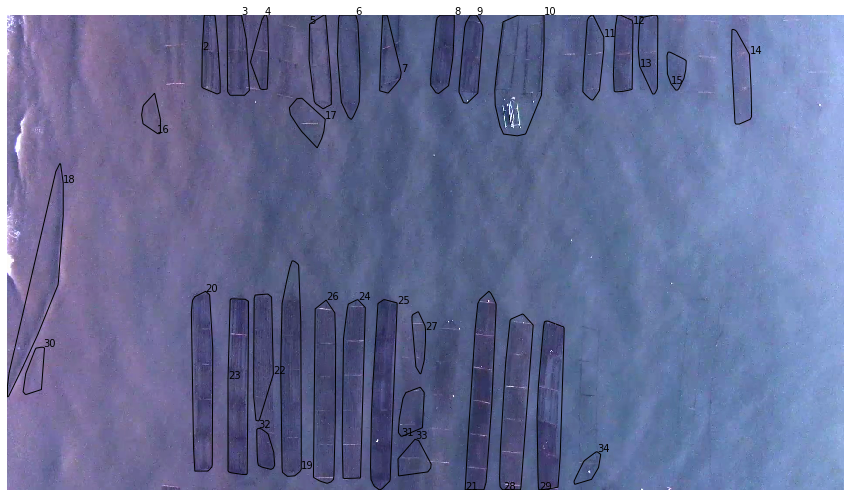

45


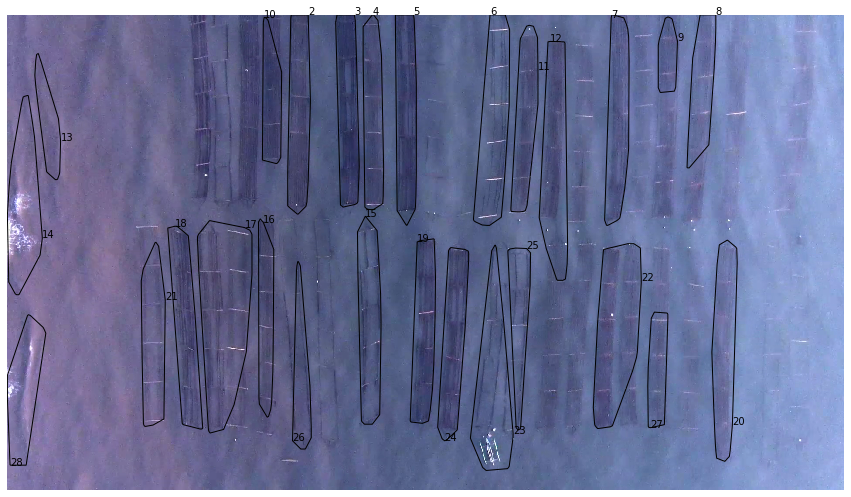

46


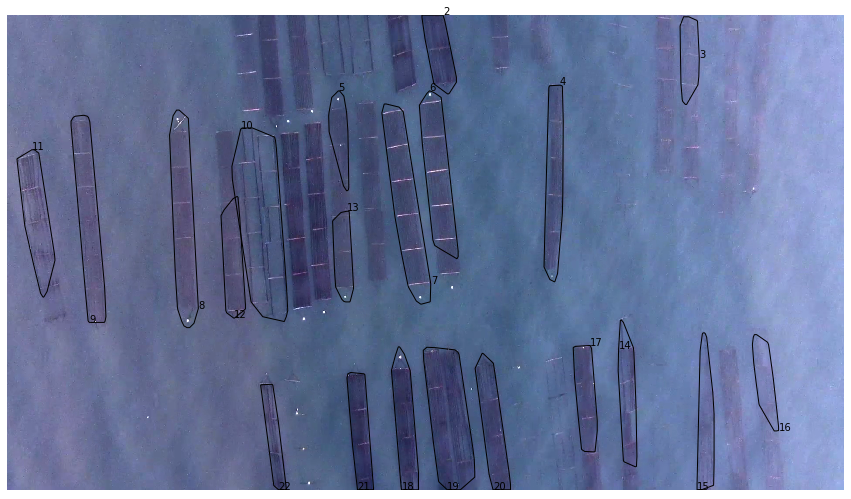

47


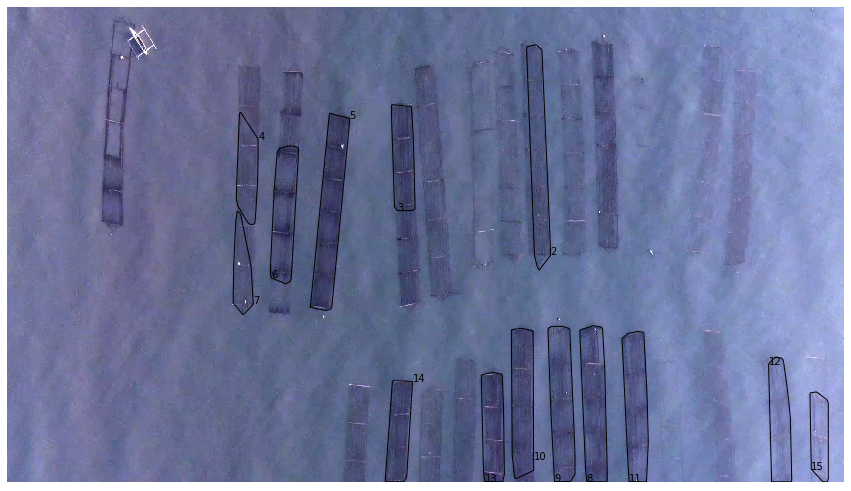

48


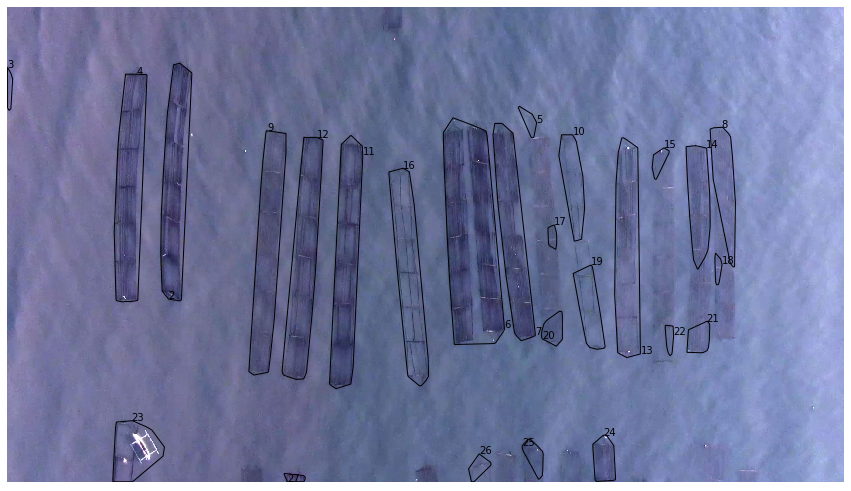

In [12]:
for filename in list_of_files[-5:]:
    
    if index!=43:
        index = index + 1
    else:
        index = index + 2
    
    imgFile = os.path.join(folder,filename)
    img = read(imgFile)
    imgrgb = readRGB(imgFile)
    img_g_applyThresh = init_thresh(img)
    img_areas = apply_iso(img_g_applyThresh)
    coords = apply_clrclo(img_areas, min_size)
    groups = applyDBSCAN(coords, eps=eps, min_samples=min_samples)
    groupLabel_Mask = applyLabels_binImg(img,coords,groups)
    coords2 = small_remover(groupLabel_Mask, percentile_range)
    groups2 = applyDBSCAN(coords2, eps=eps, min_samples=min_samples)
    groupCoords,groupHulls,groupVertices = applyConvexHull_Groups(coords2,groups2)
    groupNums = getGroupNums(groups2,include0=True)
    print(index)
    plotRGBImg_GroupsRS(imgrgb,groups2,groupNums[2:],groupVertices,scale,index,annotate=True)